In [1]:
import os
os.chdir("/content/drive/Shareddrives/yujung kim/Study/Python/time_series")

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
with open('data/pv.pickle', 'rb') as f:
    pv = pickle.load(f)

# scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
power_scaler = MinMaxScaler()
power_scaler.fit(pv[['power']])
pv['power_scale'] = power_scaler.transform(pv[['power']])

In [6]:
x_scaler = MinMaxScaler()
x_scaler.fit(pv[['alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']])
pv[['alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']] = x_scaler.transform(pv[['alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']])

In [7]:
pv = pv.set_index('datetime')

In [8]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,11,30,23,tzinfo=tz)]
pv_val = pv.loc[datetime(2006,11,24,00,tzinfo=tz):datetime(2006,12,20,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,14,00,tzinfo=tz):datetime(2006,12,31,23,tzinfo=tz)]

# data loader

- torch 에서 LSTM 의 경우 
  - input: (seq_len, batch, input_size)
  - output: (seq_len, batch, num_directions * hidden_size) 

In [9]:
from torch.utils.data import DataLoader, Dataset

In [10]:
class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, num_feature, data_comp, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        # seq_len
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples, num_feature])
        Y = np.zeros([output_window, num_samples, num_feature])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i,:] = y[start_x:end_x]
            # print(X.shape)

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]
            # print(Y.shape)

        X = X.reshape(X.shape[0], X.shape[1], num_feature).transpose((1,0,2)) # (seq_len, input_window, feature)
        Y = Y.reshape(Y.shape[0], Y.shape[1], num_feature).transpose((1,0,2)) # (seq_len, output_window, 1=power)

        if data_comp==1:
            # Y = Y[:,:,0][:,:,None]
            print(Y.shape)

        if data_comp==2:
            X = Y[:,:,1:].copy()
            Y = Y[:,:,0][:,:,None]
            print(X.shape)
            print(Y.shape)
        
        self.x = X
        self.y = Y
        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return self.len

# model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.auto import tqdm
import random

In [82]:
'''
input shape: 
    input: (batch, seq_len, num_feature) -> LSTM layer 에서 batch_first=True option 사용했을 때 기준
output shape:
    output: (batch, seq_len, hidden_dim)
    hidden_state: (batch, 1, hidden_dim) -> 각 batch 마다 제일 마지막 seq_len 기준
    cell_state: (batch, 1, hidden_dim)
'''

class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

'''
input_shape
    input: (batch, 1, num_feature) -> 직전 timestamp 기준 데이터
    hidden_state: (batch, 1, hidden_dim)
    cell_state: (batch, 1, hidden_dim)
'''

class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(1), encoder_hidden_states)
        output = self.linear(lstm_out)

        return output, self.hidden

class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)
        self.linear = nn.Linear(input_size, 1)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        # print(f"encoder input: {inputs.shape}")

        _, hidden = self.encoder(inputs)
        # print(f"encoder output: {hidden[0].shape}")

        decoder_input = inputs[:,-1,:] # 각 batch 마다 마지막 time stamp 를 decoder의 input 으로 사용
        # print(f"decoder input: {decoder_input.shape}")

        #원하는 길이가 될 때까지 decoder를 실행한다.
        # print(f"targets shape: {targets.shape}")
        # print(f"outputs shape: {outputs.shape}")
        for t in range(target_len): 
            # print(t)
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            # print(f"out shape: {out.shape}")
            
            # teacher forcing을 구현한다.
            # teacher forcing에 해당하면 다음 인풋값으로는 예측한 값이 아니라 실제 값을 사용한다.
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
                # print(f"decoder input: {decoder_input.shape}")
            else:
                decoder_input = out
                # print(f"decoder input2: {decoder_input.shape}")
            outputs[:,t,:] = out

        outputs = self.linear(outputs)

        # print(f"decoder_output: {outputs.shape}")
        return outputs


# train

In [83]:
iw = 24*7
ow = 24
num_feature = 8

train_dataset = windowDataset(pv_train[['power_scale', 'alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']], 
                              input_window=iw, output_window=ow, num_feature=num_feature, data_comp=1, stride=ow)
valid_dataset = windowDataset(pv_val[['power_scale', 'alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']], 
                             input_window=iw, output_window=ow, num_feature=num_feature, data_comp=1, stride=ow)
test_dataset = windowDataset(pv_test[['power_scale', 'alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']], 
                             input_window=iw, output_window=ow, num_feature=num_feature, data_comp=1, stride=ow)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

(327, 24, 8)
(20, 24, 8)
(11, 24, 8)


In [84]:
a = next(iter(train_loader))
print(a[0].shape)
print(a[1].shape)

torch.Size([64, 168, 8])
torch.Size([64, 24, 8])


In [85]:
def train(model, train_loader, optimizer, criterion, device='cuda'):
    model.train()
    total_loss = 0.0

    for x, y in train_loader:
        optimizer.zero_grad()
        x = x.to(device).float()
        y = y.to(device).float()

        output = model(x, y, ow, 0.5).to(device)

        # print(f"x shape: {x.shape}")
        # print(f"y shape: {y.shape}")
        # print(f"pred shape: {output.shape}")
        # print(f"final y shape: {y[:,:,0].shape}")
        # print(f"final pred shape: {output[:,:,0].shape}")

        loss = criterion(output[:,:,0], y[:,:,0])
        loss.backward()
        optimizer.step()
        total_loss += loss.cpu().item()

    train_loss = total_loss/len(train_loader)
    
    return output.detach().cpu().numpy(), y.detach().cpu().numpy(), train_loss

def predict(model, test_loader, criterion, device='cuda', file_name=None):
    model.eval()

    total_loss = 0.0
    outputs = []
    ys = []

    for t, (x, y) in enumerate(test_loader):
        # print(t)
        x = x.to(device).float()
        y = y.to(device).float()

        with torch.no_grad():
            output = model(x, y, ow, 0.0).to(device)
        # print(output.shape)
        # outputs[t,:,:,:] = output
        outputs.append(list(output.detach().cpu().numpy()))
        ys.append(list(y.detach().cpu().numpy()))
        loss = criterion(output[:,:,0], y[:,:,0])
        total_loss += loss.cpu().item()

    test_loss = total_loss/len(test_loader)

    if file_name:
        torch.save(model.state_dict(), file_name)

    return np.array(sum(outputs,[])), np.array(sum(ys,[])), test_loss

# model

In [86]:
# wandb.init(name=str(param), project="TCN_data_composition_1", entity="yyyyyjkim")

In [106]:
param_config = {
    "learning_rate": 0.001,
    "epochs": 1000,
    "input_size": 8,
    "hidden_size": 20
}

In [107]:
device='cpu'
model = lstm_encoder_decoder(input_size=param_config['input_size'], hidden_size=param_config['hidden_size']).to(device)

learning_rate=param_config['learning_rate']
epoch = param_config['epochs']
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [108]:
# 파라미터 수 계산
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,977 trainable parameters


In [109]:
# wandb.watch(model, log='all', log_freq=10)

val_loss_min = 100
file_name = 'model/basic.model'

pbar = tqdm(range(param_config['epochs']))
for epoch in pbar:
    *result_train, train_loss = train(model, train_loader, optimizer, criterion, device='cpu')
    *result_val, val_loss = predict(model, val_loader, criterion, device='cpu')
    *result_test, test_loss = predict(model, test_loader, criterion, device='cpu')

    if val_loss < val_loss_min:
        val_loss_min = val_loss
        torch.save(model.state_dict(), file_name)
        print(f"epoch: {epoch} / val_loss: {val_loss:.5f} / test_loss: {test_loss:.5f}")

    # wandb.log({"train_loss": train_loss, "val_loss": val_loss, "test_loss": test_loss, "val_loss_min": val_loss_min})

    pbar.set_postfix(loss=f"train_loss: {train_loss:.5f} / val_loss: {val_loss:.5f} / test_loss: {test_loss:.5f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 0 / val_loss: 0.08544 / test_loss: 0.04103
epoch: 1 / val_loss: 0.08110 / test_loss: 0.04203
epoch: 2 / val_loss: 0.07823 / test_loss: 0.04432
epoch: 3 / val_loss: 0.07648 / test_loss: 0.04719
epoch: 4 / val_loss: 0.07520 / test_loss: 0.04899
epoch: 5 / val_loss: 0.07414 / test_loss: 0.04876
epoch: 6 / val_loss: 0.07370 / test_loss: 0.04797
epoch: 7 / val_loss: 0.07327 / test_loss: 0.04745
epoch: 8 / val_loss: 0.07273 / test_loss: 0.04742
epoch: 9 / val_loss: 0.07218 / test_loss: 0.04787
epoch: 10 / val_loss: 0.07150 / test_loss: 0.04875
epoch: 11 / val_loss: 0.07051 / test_loss: 0.04907
epoch: 12 / val_loss: 0.06900 / test_loss: 0.04869
epoch: 13 / val_loss: 0.06635 / test_loss: 0.04895
epoch: 14 / val_loss: 0.06054 / test_loss: 0.04890
epoch: 15 / val_loss: 0.04940 / test_loss: 0.05026
epoch: 16 / val_loss: 0.03426 / test_loss: 0.04859
epoch: 17 / val_loss: 0.02198 / test_loss: 0.04177
epoch: 18 / val_loss: 0.01702 / test_loss: 0.04122
epoch: 24 / val_loss: 0.01681 / test_loss

In [75]:
wandb.finish()

NameError: ignored

In [110]:
pred_val = result_val[0]
pred_val = power_scaler.inverse_transform(pred_val[:,:,0].reshape(-1,1))
print(f"pred_val: {len(pred_val)}")

pred_test = result_test[0]
pred_test = power_scaler.inverse_transform(pred_test[:,:,0].reshape(-1,1))
print(f"pred_test: {len(pred_test)}")

pred_val: 480
pred_test: 264


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

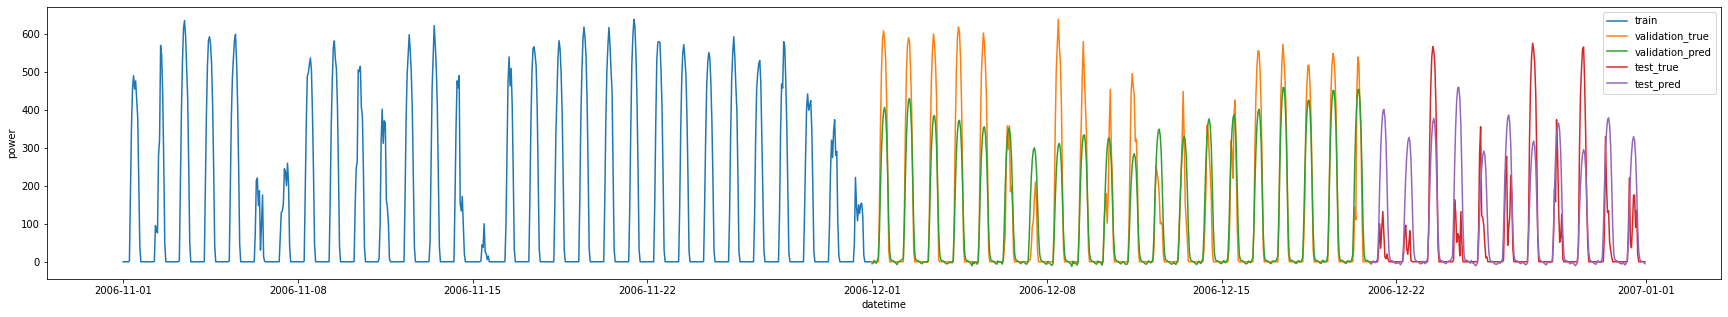

In [111]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):]['power'], label='train')
sns.lineplot(pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'], label='validation_true')
sns.lineplot(pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pred_val.reshape(-1), label='validation_pred')
sns.lineplot(pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):].index, pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):]['power'], label='test_true')
sns.lineplot(pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):].index, pred_test.reshape(-1), label='test_pred')
plt.legend()

In [112]:
model.load_state_dict(torch.load(file_name))
*result_val, val_loss = predict(model, val_loader, criterion, device='cpu')
*result_test, test_loss = predict(model, test_loader, criterion, device='cpu')

In [113]:
pred_val = result_val[0]
pred_val = power_scaler.inverse_transform(pred_val[:,:,0].reshape(-1,1))
print(f"pred_val: {len(pred_val)}")

pred_test = result_test[0]
pred_test = power_scaler.inverse_transform(pred_test[:,:,0].reshape(-1,1))
print(f"pred_test: {len(pred_test)}")

pred_val: 480
pred_test: 264


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

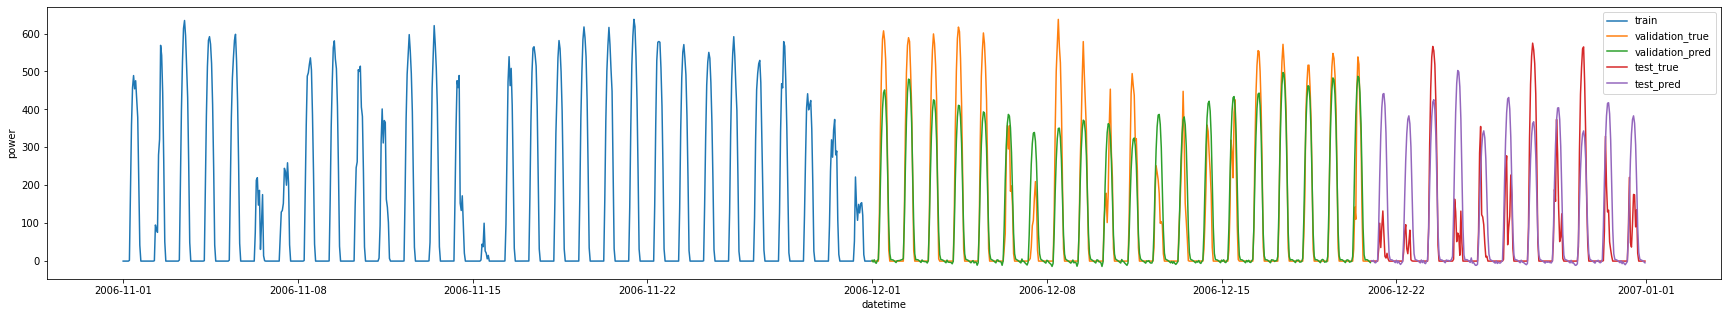

In [114]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):]['power'], label='train')
sns.lineplot(pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'], label='validation_true')
sns.lineplot(pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pred_val.reshape(-1), label='validation_pred')
sns.lineplot(pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):].index, pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):]['power'], label='test_true')
sns.lineplot(pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):].index, pred_test.reshape(-1), label='test_pred')
plt.legend()